# Membuat Classifier nya

In [1]:
import tensorflow as tf

In [2]:
# Define Input Parameters
dim = (150, 150)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

# Membuat dataset generator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [5]:
#binary = [1,0,0,0] #categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 3457 images belonging to 5 classes.
Found 433 images belonging to 5 classes.
Found 433 images belonging to 5 classes.


In [8]:
num_class = test_generator.num_classes

# Membuat Struktur CNN

## Manualy define network

In [40]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

In [41]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [42]:
# model.summary()

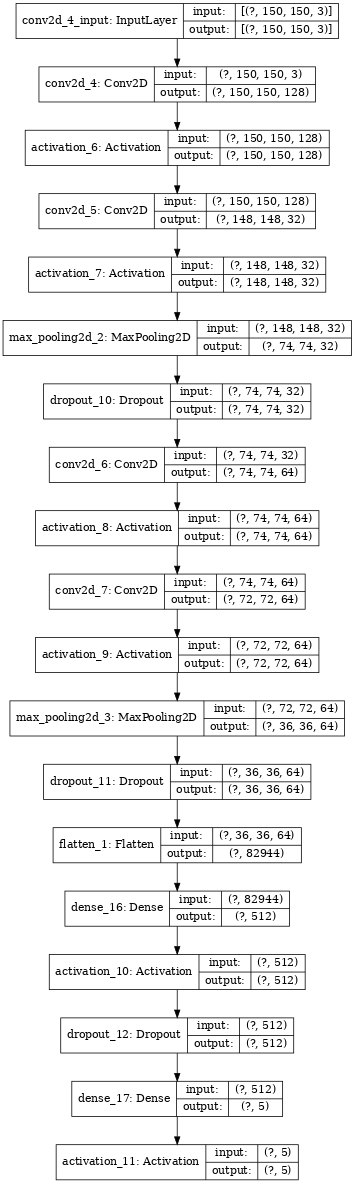

In [43]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=False,
                          dpi=55)
model_viz

## Transfer Learning

In [14]:
# !pip install -U --pre efficientnet

In [15]:
from efficientnet.tfkeras import EfficientNetB1

### Build Base model

In [48]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

### Add top network layer to models

In [49]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [50]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [51]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [52]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Visualize The final model

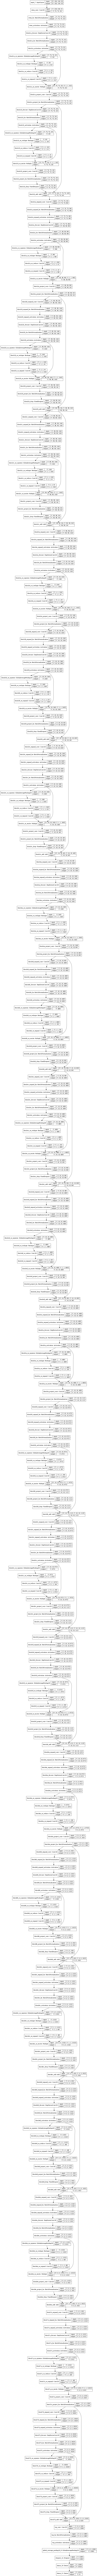

In [53]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=False,
                          dpi=55)
model_viz

# Train Model

In [54]:
from multiprocessing import cpu_count

In [56]:
EPOCH = 2
WORKERS = cpu_count()

In [57]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=EPOCH,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              workers=WORKERS,
                              use_multiprocessing=True,
                              shuffle=True,
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 217 steps, validate for 28 steps
Epoch 1/2
217/217 [==============================] - 2075s 10s/step - loss: 0.6809 - accuracy: 0.7599 - val_loss: 0.6896 - val_accuracy: 0.8083
Epoch 2/2
217/217 [==============================] - 2074s 10s/step - loss: 0.4870 - accuracy: 0.8363 - val_loss: 0.3810 - val_accuracy: 0.8707


In [58]:
history.history['loss']
history.history['accuracy']

[0.7599074, 0.8362742]

# Plot the training

In [59]:
from matplotlib import pyplot as plt

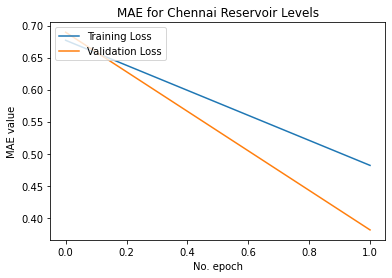

In [60]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

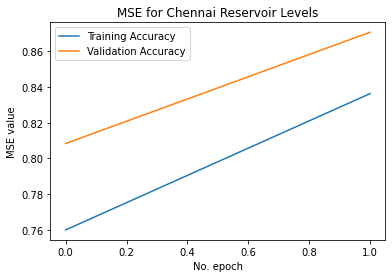

In [61]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Evaluate Models

In [63]:
loss, acc = model.evaluate_generator(train_generator,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \n Loss on training data: {:.4f}'.format(acc,loss))
 
loss, acc = model.evaluate_generator(test_generator,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \n Loss on test data: {:.4f}'.format(acc,loss))    

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Accuracy on training data: 0.9196 
 Loss on training data: 0.2762
  ...
    to  
  ['...']
Accuracy on test data: 0.8545 
 Loss on test data: 0.4062
